Общий вид мультипликативной модели выглядит так:  
$Y = T\bullet S\bullet E$

Процесс построения модели включает в себя следующие шаги:  
1. Выравнивание исходного ряда методом скользящей средней.
2. Расчет значений сезонной компоненты $S$.
3. Устранение сезонной компоненты из исходных уровней ряда и
получение выровненных данных ($T+E$) в аддитивной или ($T\bullet E$)
мультипликативной модели.
4. Аналитическое выравнивание уровней ($T+E$) или ($T\bullet E$) и расчет
значений T с использованием полученного уравнения тренда.
5. Расчет полученных по модели значений ($T+E$) или ($T\bullet E$).
6. Расчет абсолютных и/или относительных ошибок

## Импорт библиотек

In [1]:
import pandas as pd
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
import numpy as np

## Загрузка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_excel('data/Сводный отчет за декабрь.xlsx', header=1)

,Сумма Y(t)
День t,
1,590.0
2,19900.0
3,16200.0
4,2570.0
5,7330.0


<Axes: xlabel='День t'>

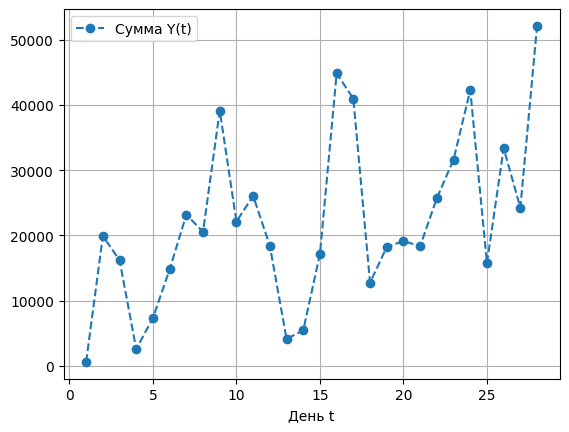

In [16]:
if 'Название ККТ' in data.columns:
    # выберем данные с одной точки
    data = data[data['Название ККТ'] == 'ТРЦ "Фокус"']
    # выберем только данные прихода
    data = data[data['Тип операции'] == 'Приход']
    data['День t'] = data['Дата и время'].apply(lambda x: x.day)

    data.drop(columns=['Тип операции', 'Наличными', 'Безналичными', 'Название ККТ', 'Дата и время'], inplace=True)
    data.rename(columns = {
        'Сумма': 'Сумма Y(t)'
    }, inplace=True)
df = data.groupby(['День t']).sum().head(28)
display(df.head())
df.plot(style='--o', grid=True)

### 1. Проведем выравнивание исходных уравнений ряда методом скользящей средней

In [17]:
n = 4
df['Скользящая средняя за {n} дней'] = np.nan
for i in range(len(df) - n + 1):
    df[df.columns[1]].loc[i+int(n/2)] = \
        df[df.columns[0]].loc[i:i+n].mean()

In [18]:
df['Центрированная cкользящая средняя'] = np.nan
for i in range(len(df) - 1):
    temp_data = df[df.columns[1]].loc[i+1:i+2] # текущее и предыдущее знач.
    if temp_data.isnull().any(): continue # если среди данных есть Nan
    df[df.columns[2]].loc[i+1] = temp_data.mean() # берем среднее по ним

In [19]:
df['Оценка сезонной компоненты'] = df[df.columns[0]] - df[df.columns[2]]
display(df)

,Сумма Y(t),Скользящая средняя за {n} дней,Центрированная cкользящая средняя,Оценка сезонной компоненты
День t,,,,
1,590.0,NaN,NaN,NaN
2,19900.0,9815.0,9566.50,10333.50
3,16200.0,9318.0,10737.00,5463.00
4,2570.0,12156.0,12484.00,-9914.00
5,7330.0,12812.0,13247.00,-5917.00
6,14780.0,13682.0,17338.00,-2558.00
7,23180.0,20994.0,22473.00,707.00
8,20550.0,23952.0,25081.00,-4531.00
9,39130.0,26210.0,25731.00,13399.00


Результирующая таблица шага 1.

### 2. Расчет значений сезонной компоненты в аддитивной модели


сгрупируем по годам оценку сезонной компоненты

In [20]:
g_column = 'Неделя'
df[g_column] = (df.index + 5) // 7 # поправка на то, что декабрь начался с пятницы
##df[df.columns[3:5]].groupby([g_column]).sum()
dataFrame = df.groupby([g_column])\
    .agg({'Оценка сезонной компоненты': lambda arg: list(arg)})\
    ['Оценка сезонной компоненты'].apply(pd.Series)\
    .rename(columns={i: f"{['Пн','Вт','Ср','Чт','Пт','Сб','Вс'][i]}" for i in range(7)})
dataFrame.round().replace(np.nan, '')

,Пн,Вт,Ср,Чт,Пт,Сб,Вс
Неделя,,,,,,,
0,,,,,,,
1,10334.0,5463.0,-9914.0,-5917.0,-2558.0,707.0,-4531.0
2,13399.0,-1489.0,7474.0,3662.0,-11988.0,-14813.0,-6222.0
3,19346.0,13977.0,-11791.0,-2126.0,-1590.0,-6675.0,-1364.0
4,3371.0,12695.0,-15759.0,,,,


In [21]:
dataFrame.index = \
    pd.MultiIndex.from_product([[''],list(range(len(dataFrame)))], names = ['Показатели', 'День'])

In [22]:
dataFrame.loc[('Итого за i-тый квартал',''), :] = dataFrame.loc[''].sum()
dataFrame.loc[('Средняя оценка сезонной компоненты для i-го квартала',''), :] = \
    dataFrame.loc[''].mean()
dataFrame.loc[('Скорректированная сезонная компонента',''), :] = \
    dataFrame.loc[('Средняя оценка сезонной компоненты для i-го квартала','')] - \
    dataFrame.loc[('Средняя оценка сезонной компоненты для i-го квартала','')].mean()
dataFrame.loc[('Корректирующий коэффициет',
    dataFrame.loc[('Средняя оценка сезонной компоненты для i-го квартала','')].mean().round(3)
              ), :] = ''
dataFrame['Сумма'] = ''
for column in ['Средняя оценка сезонной компоненты для i-го квартала','Скорректированная сезонная компонента']:
    dataFrame.loc[(column,''), 'Сумма'] = \
        dataFrame.loc[(column,''),dataFrame.columns[0:-1]].sum()

In [23]:
round(dataFrame,3)

Пн   
Показатели                                         День                    
                                                   0                 NaN  \
                                                   1             10333.5   
                                                   2             13399.0   
                                                   3             19346.0   
                                                   4              3371.0   
Итого за i-тый квартал                                           46449.5   
Средняя оценка сезонной компоненты для i-го ква...             11612.375   
Скорректированная сезонная компонента                       12473.594643   
Корректирующий коэффициет                          -861.22                 

                                                                     Вт   
Показатели                                         День                   
                                                   0                NaN  \
                                                   1             5463.0   
                                                   2            -1489.0   
                                                   3            13977.0   
                                                   4            12695.0   
Итого за i-тый квартал                                          30646.0   
Средняя оценка сезонной компоненты для i-го ква...               7661.5   
Скорректированная сезонная компонента                       8522.719643   
Корректирующий коэффициет                          -861.22                

                                                                     Ср   
Показатели                                         День                   
                                                   0                NaN  \
                                                   1            -9914.0   
                                                   2             7474.0   
                                                   3           -11791.0   
                                                   4          -15758.65   
Итого за i-тый квартал                                        -29989.65   
Средняя оценка сезонной компоненты для i-го ква...           -7497.4125   
Скорректированная сезонная компонента                      -6636.192857   
Корректирующий коэффициет                          -861.22                

                                                                     Чт   
Показатели                                         День                   
                                                   0                NaN  \
                                                   1            -5917.0   
                                                   2             3662.0   
                                                   3            -2126.0   
                                                   4                NaN   
Итого за i-тый квартал                                          -4381.0   
Средняя оценка сезонной компоненты для i-го ква...         -1460.333333   
Скорректированная сезонная компонента                        -599.11369   
Корректирующий коэффициет                          -861.22                

                                                                     Пт   
Показатели                                         День                   
                                                   0                NaN  \
                                                   1            -2558.0   
                                                   2           -11988.0   
                                                   3            -1590.0   
                                                   4                NaN   
Итого за i-тый квартал                                         -16136.0   
Средняя оценка сезонной компоненты для i-го ква...         -5378.666667   
Скорректированная сезонная компонента                      -4517.447024   
Корре

### Расчет выровнненых значений T и ошибок Е в аддитивной модели
Элиминируем влияние сезонной компоненты:  

Вычитем значение сезонной компоненты из каждого уровня исходного временного ряда. Получим величины $T + E = Y + S$. Эти значения рассчитываются за каждый момент времени и содержат только тенденцию и случайную компоненту.

In [24]:
v = list(dataFrame.loc[('Скорректированная сезонная компонента',''),dataFrame.columns[0:-1]])

In [25]:
df3= df.drop(columns=df.columns[1:])

df3['Скорректировання сезонная компонента, Si'] = [*(v * 5)][:len(df3)]

df3['T+E=Y+S'] = df3[df.columns[0]] - df3['Скорректировання сезонная компонента, Si'] 

least_sq_coefs = np.polyfit(df3['T+E=Y+S'].iloc[0:16].index, df3['T+E=Y+S'].iloc[0:16], deg=1)
least_sq_func = np.poly1d(least_sq_coefs)

df3['T'] = least_sq_func(list(df3['T+E=Y+S'].index))
df3['T+S'] = df3['T'] + df3['Скорректировання сезонная компонента, Si']
df3['E=yt-(T+S)'] = df3[df.columns[0]] - df3['T+S']
df3['$E^2$'] = df3['E=yt-(T+S)'].pow(2)

#df3.loc['Среднее:',[df.columns[0], 'E=yt-(T+S)' ,'$E^2$']] = [df3[df.columns[0]].mean(), '$\b Сумма:$', df3['$E^2$'].sum()]
df3.loc['Среднее:'] = df3.mean()
df3.loc['Сумма:'] = df3.iloc[:-1].sum()

df3.round(3).replace(np.nan, '')

,Сумма Y(t),"Скорректировання сезонная компонента, Si",T+E=Y+S,T,T+S,E=yt-(T+S),$E^2$
День t,,,,,,,
1,590.000,12473.595,-11883.595,8847.598,21321.193,-20731.193,4.297824e+08
2,19900.000,8522.720,11377.280,9845.866,18368.585,1531.415,2.345231e+06
3,16200.000,-6636.193,22836.193,10844.133,4207.941,11992.059,1.438095e+08
4,2570.000,-599.114,3169.114,11842.401,11243.287,-8673.287,7.522591e+07
5,7330.000,-4517.447,11847.447,12840.669,8323.222,-993.222,9.864892e+05
6,14780.000,-6065.780,20845.780,13838.936,7773.156,7006.844,4.909586e+07
7,23180.000,-3177.780,26357.780,14837.204,11659.424,11520.576,1.327237e+08
8,20550.000,12473.595,8076.405,15835.472,28309.066,-7759.066,6.020311e+07
9,39130.000,8522.720,30607.280,16833.739,25356.459,13773.541,1.897104e+08


Сумма абсолютных ошибок составила

### 4. Выведем график полученной модели

Для данных до 28 декабря

Таким образом, имеет линейный тренд: T = 7849.33 + 998.268 * t


<Axes: xlabel='День t'>

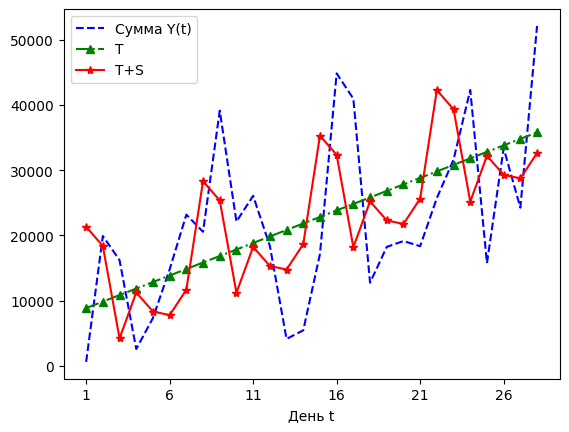

In [26]:
print(f'Таким образом, имеет линейный тренд: '
      f'T = {least_sq_coefs[1]:.2f} + {least_sq_coefs[0]:.3f} * t')
df3[[df3.columns[0],'T','T+S']].iloc[:-2].plot(style=['b--','g^-.','r*-'])

Для полных данных до 31 декабря

Таким образом, имеет линейный тренд: T = 7837.04 + 995.862 * t


<Axes: xlabel='День t'>

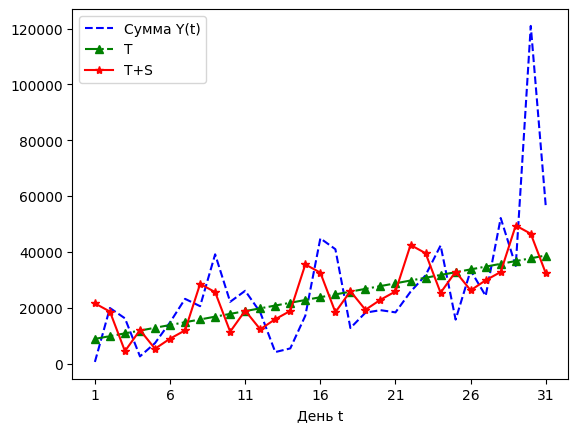

In [14]:
print(f'Таким образом, имеет линейный тренд: '
      f'T = {least_sq_coefs[1]:.2f} + {least_sq_coefs[0]:.3f} * t')
df3[[df3.columns[0],'T','T+S']].iloc[:-2].plot(style=['b--','g^-.','r*-'])

### 5. Предскажем уровни потребления на 17 и 18 кварталы

T для 17 и 18 равна 8,9 и 9,1 соответстенно. S - равна 0,58 и -1,98.  
Тогда предсказанные значения (T + S) равны 9,47 и 7,01. Значения представлены в таблице.

##### Характеристики регрессионной модели были приведены в работе, но не были описаны способы их получения. Поэтому для их вычисления воспользовался пакетом statsmodels

In [27]:
import statsmodels.api as sm
x = sm.add_constant(np.array(list(df3['T+E=Y+S'].iloc[0:16].index.values)))
Y = df3['T+E=Y+S'].iloc[0:16].values
olsmod = sm.OLS(Y, x)
olsres = olsmod.fit()
display(olsres.summary())

C:\Users\Evgen\NeuralNetworks\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     2.316
Date:                Mon, 15 Jan 2024   Prob (F-statistic):              0.150
Time:                        01:56:05   Log-Likelihood:                -172.04
No. Observations:                  16   AIC:                             348.1
Df Residuals:                      14   BIC:                             349.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7849.3305   6342.820      1.238      0.236   -5754.665    2.15e+04
x1           998.2676    655.959      1.522      0.150    -408.624    2405.159
==============================================================================
Omnibus:                        2.902   Durbin-Watson:                   1.568
Prob(Omnibus):                  0.234   Jarque-Bera (JB):                1.453
Skew:                          -0.412   Prob(JB):                        0.483
Kurtosis:                       1.775   Cond. No.                         20.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""